In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

from collections import deque
from torch.utils.data import DataLoader
from tqdm.autonotebook import tqdm

import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

# from utils import save_model, load_model, augmented_train_set, augmented_val_set
from utils import save_model, load_model, get_augmented_data
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

/tmp/ipykernel_819/2428511358.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


train_set size=60000
val_set size=10000


In [ ]:

class Encoder(nn.Module):
    def __init__(self, img_size, label_size, latent_size, hidden_size):
        super(Encoder, self).__init__()
        self.img_size = img_size  # (C, H, W)
        self.label_size = label_size
        self.latent_size = latent_size
        self.hidden_size = hidden_size
        
        self.flat_img_size = img_size[0] * img_size[1] * img_size[2]
        self.fc_img_enc = nn.Linear(self.flat_img_size, self.hidden_size)
        self.fc_lbl_enc = nn.Linear(self.label_size, self.hidden_size)
        self.encoder = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.encoder2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.fc_mu = nn.Linear(self.hidden_size, self.latent_size)
        self.fc_logstd = nn.Linear(self.hidden_size, self.latent_size)

    def forward(self, x, y):
        x = x.view(x.size(0), -1).float()
        y = y.float()
        x = F.relu(self.fc_img_enc(x))
        y = F.relu(self.fc_lbl_enc(y))
        x = torch.cat((x, y), dim=1)
        x = F.relu(self.encoder(x))
        x = F.relu(self.encoder2(x))
        mu = self.fc_mu(x)
        logstd = self.fc_logstd(x)
        return mu, logstd

    def reparametrize(self, mu: torch.Tensor, logstd: torch.Tensor):
        std_dev = torch.exp(logstd * 0.5)
        eps = torch.randn_like(std_dev)
        z = mu + eps * std_dev
        return z

    def encode(self, x, y):
        mu, logstd = self.forward(x, y)
        z = self.reparametrize(mu, logstd)
        return z, mu, logstd


class Decoder(nn.Module):
    def __init__(self, img_size, label_size, latent_size, hidden_size):
        super(Decoder, self).__init__()
        self.img_size = img_size  # (C, H, W)
        self.label_size = label_size
        self.latent_size = latent_size
        self.hidden_size = hidden_size
        
        self.fc_latent = nn.Linear(self.latent_size, self.hidden_size)
        self.fc_lbl_dec = nn.Linear(self.label_size, self.hidden_size)
        self.decoder = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.decoder2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.fc_dec = nn.Linear(self.hidden_size, self.flat_img_size)

    @property
    def flat_img_size(self):
        return self.img_size[0] * self.img_size[1] * self.img_size[2]

    def forward(self, z, y):
        y = y.float()
        z = F.relu(self.fc_latent(z))
        y = F.relu(self.fc_lbl_dec(y))
        z = torch.cat((z, y), dim=1)
        z = F.relu(self.decoder(z))
        z = F.relu(self.decoder2(z))
        x = self.fc_dec(z)
        x = x.view(x.size(0), *self.img_size)
        x = torch.sigmoid(x)  # Apply sigmoid activation to get pixel values in [0, 1]
        return x

class CVAE(nn.Module):
    def __init__(self, img_size, label_size, latent_size, hidden_size):
        super(CVAE, self).__init__()
        self.img_size = img_size  # (C, H, W)
        self.label_size = label_size
        self.latent_size = latent_size
        self.hidden_size = hidden_size
        self.encoder = Encoder(img_size, label_size, latent_size, hidden_size)
        self.decoder = Decoder(img_size, label_size, latent_size, hidden_size)
        
    def forward(self, x, y):
        z, mu, logstd = self.encoder.encode(x, y)
        x_recon = self.decoder(z, y)
        return x_recon, mu, logstd
    
    def encode_param(self, x, y):
        # compute mu and logstd of p(z|x)
        mu, logstd = self.encoder(x, y)
        return mu, logstd
    
    def  reparamaterize(self, mu: torch.Tensor, logstd: torch.Tensor):
        # compute latent z with reparameterization trick
        std_dev = torch.exp(logstd*0.5)
        eps = torch.randn_like(std_dev)
        z = mu + eps * std_dev
        return z
    
    def encode(self, x, y):
        # sample latent z from p(z|x)
        mu, logstd = self.encode_param(x, y)
        z = self.reparamaterize(mu, logstd)
        return z, mu, logstd
    
    def decode(self, z, y):
        recon_x = self.decoder(z, y)
        return recon_x
    
    @torch.no_grad()
    def sample_images(self, label, save=True, save_dir='./vae'):
        self.eval()
        n_samples = label.shape[0]
        samples  = self.decoder.decode(torch.randn(n_samples, self.latent_size).to(label.device), label)
        imgs = samples.view(n_samples, 1, 28, 28).clamp(0., 1.)
        if save:
            os.makedirs(save_dir, exist_ok=True)
            torchvision.utils.save_image(imgs, os.path.join(save_dir, 'sample.png'), nrow=int(np.sqrt(n_samples)))
        return imgs
    

In [ ]:
en_drate_schedule = torch.linspace(0.0, 1.0, 5)
de_drate_schedule = torch.linspace(0.0, 1.0, 5)

label_dim = 11
img_dim = (1, 28, 28)
latent_dim = 10
hidden_dim = 400

augmented_train_set, augmented_val_set = get_augmented_data()
train_loader = DataLoader(augmented_train_set, batch_size=512, shuffle=True)
val_loader = DataLoader(augmented_val_set, batch_size=512, shuffle=False)

augmented_imgs size=torch.Size([100000, 1, 28, 28])
augmented_labels size=torch.Size([100000, 4])


In [4]:
en_drate = 0.0
de_drate = 0.0

drate = f"{en_drate}_{de_drate}"
path = "vae_models"
encoder_path = os.path.join(path, f"encoder_{drate}.pth")
decoder_path = os.path.join(path, f"decoder_{drate}.pth")


vae_model = CVAE(img_size=img_dim, label_size=label_dim, latent_size=latent_dim, hidden_size=hidden_dim).to(device)
encoder = vae_model.encoder
decoder = vae_model.decoder

encoder.load_state_dict(torch.load(encoder_path)["model"])
decoder.load_state_dict(torch.load(decoder_path)["model"])
encoder.eval()
decoder.eval()

Decoder(
  (fc_latent): Linear(in_features=20, out_features=400, bias=True)
  (fc_lbl_dec): Linear(in_features=11, out_features=400, bias=True)
  (decoder): Linear(in_features=800, out_features=400, bias=True)
  (decoder2): Linear(in_features=400, out_features=400, bias=True)
  (fc_dec): Linear(in_features=400, out_features=784, bias=True)
)

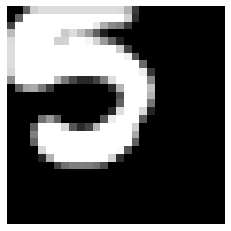

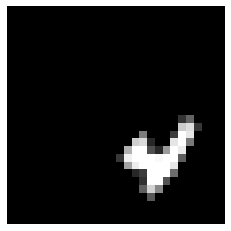

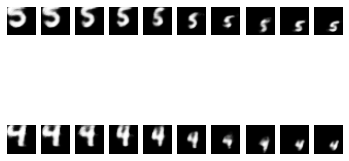

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# choose pic1 by specific labels

def find_img(augmented_train_set, lbl1):
    for i, (x, y) in enumerate(augmented_train_set):
        if y[0] == lbl1[0] and y[1] == lbl1[1] and y[2] == lbl1[2] and y[3] == lbl1[3]:
            plt.imshow(x[0].cpu().numpy(), cmap='gray')
            plt.axis('off')
            plt.show()
            return x[0]
    print("Image not found, sample one instead.")
    tmp_vae_model = CVAE(img_size=img_dim, label_size=label_dim, latent_size=latent_dim, hidden_size=hidden_dim).to(device)
    tmp_vae_model.load_state_dict(torch.load("vae_models/vae_model_0.0_0.0.pth")["model"])
    tmp_vae_model.eval()
    for i, (x, y) in enumerate(augmented_train_set):
        if y[1] == lbl1[1] and y[2] == lbl1[2] and y[3] == lbl1[3]:
            original_img = x[0]
            original_img = original_img.unsqueeze(0).to(device)
            sample_img, _, _ = tmp_vae_model.forward(original_img, torch.tensor(lbl1[0]).unsqueeze(0).to(device))
            sample_img = sample_img.squeeze(0).cpu().numpy()
            plt.imshow(sample_img, cmap='gray')
            plt.axis('off')
            plt.show()
            return sample_img
    raise ValueError("Image not found in the dataset.")

lbl1 = [5, 0, 2, 2]
lbl2 = [4, 8, 0, 0]

pic1 = find_img(augmented_train_set, lbl1)
pic2 = find_img(augmented_train_set, lbl2)

pic1 = pic1.unsqueeze(0).to(device)
pic2 = pic2.unsqueeze(0).to(device)

z1, _, _ = vae_model.encode(pic1, torch.tensor(lbl1[0]).unsqueeze(0).to(device))
z2, _, _ = vae_model.encode(pic2, torch.tensor(lbl2[0]).unsqueeze(0).to(device))

n_interpolations = 10
linespace = torch.linspace(0, 1, n_interpolations).to(device)
for i in range(n_interpolations):
    z = (1 - linespace[i]) * z1 + linespace[i] * z2
    recon_x1 = vae_model.decode(z, torch.tensor(lbl1[0]).unsqueeze(0).to(device))
    recon_x1 = recon_x1.view(recon_x1.size(0), 1, 28, 28).clamp(0., 1.).detach()
    plt.subplot(2, n_interpolations, i + 1)
    plt.imshow(recon_x1[0][0].cpu().numpy(), cmap='gray')
    plt.axis('off')
    recon_x2 = vae_model.decode(z, torch.tensor(lbl2[0]).unsqueeze(0).to(device))
    recon_x2 = recon_x2.view(recon_x2.size(0), 1, 28, 28).clamp(0., 1.).detach()
    plt.subplot(2, n_interpolations, i + 1 + n_interpolations)
    plt.imshow(recon_x2[0][0].cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.show()


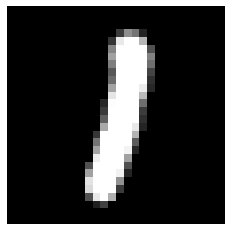

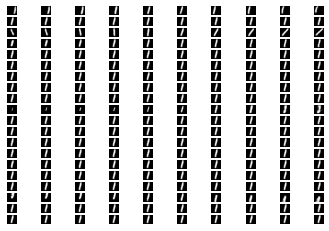

In [6]:
lbl1 = [1, 4, 2, 2]

pic1 = find_img(augmented_train_set, lbl1)

pic1 = pic1.unsqueeze(0).to(device)
pic2 = pic2.unsqueeze(0).to(device)

z1, _, _ = vae_model.encode(pic1, torch.tensor(lbl1[0]).unsqueeze(0).to(device))

linespace = torch.linspace(-3, 3, n_interpolations).to(device)

for h in range(latent_dim):
    for i in range(n_interpolations):
        z = z1.clone()
        z[0][h] = linespace[i]
        recon_x1 = vae_model.decode(z, torch.tensor(1).unsqueeze(0).to(device))
        recon_x1 = recon_x1.view(recon_x1.size(0), 1, 28, 28).clamp(0., 1.).detach()
        plt.subplot(latent_dim, n_interpolations, h * n_interpolations + i + 1)
        plt.imshow(recon_x1[0][0].cpu().numpy(), cmap='gray')
        plt.axis('off')


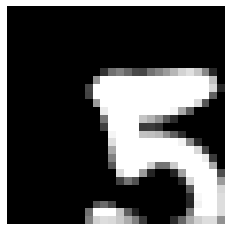

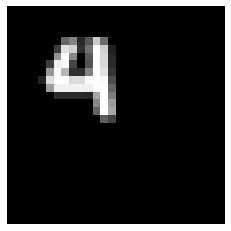

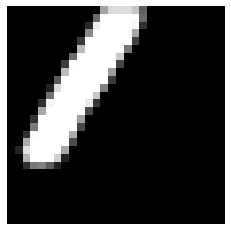

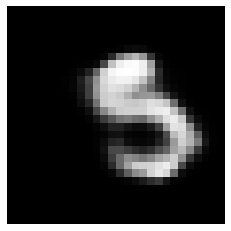

In [73]:
lbl1 = [5, 8, 2, 2]
lbl2 = [4, 0, 0, 0]
lbl3 = [1, 0, 2, 2]

pic1 = find_img(augmented_train_set, lbl1)
pic2 = find_img(augmented_train_set, lbl2)
pic3 = find_img(augmented_train_set, lbl3)

pic1 = pic1.unsqueeze(0).to(device)
pic2 = pic2.unsqueeze(0).to(device)
pic3 = pic3.unsqueeze(0).to(device)

z1, _, _ = vae_model.encode(pic1, torch.tensor(lbl1[0]).unsqueeze(0).to(device))
z2, _, _ = vae_model.encode(pic2, torch.tensor(lbl2[0]).unsqueeze(0).to(device))
z3, _, _ = vae_model.encode(pic3, torch.tensor(lbl3[0]).unsqueeze(0).to(device))

z_new = z1 + z2
recon_x = vae_model.decode(z_new, torch.tensor(lbl1[0]).unsqueeze(0).to(device))
recon_x = recon_x.view(recon_x.size(0), 1, 28, 28).clamp(0., 1.).detach()
plt.imshow(recon_x[0][0].cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

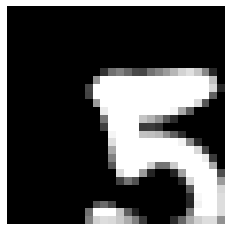

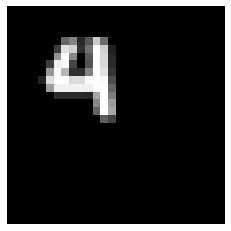

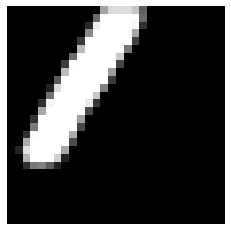

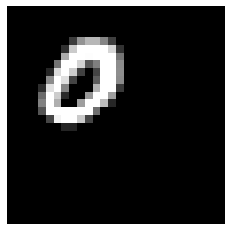

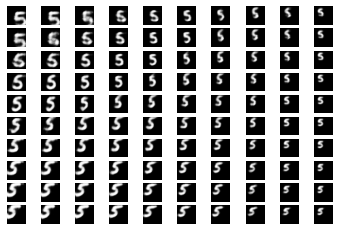

In [7]:
# 4-pic interpolation
lbl1 = [5, 8, 2, 2]
lbl2 = [4, 0, 0, 0]
lbl3 = [1, 0, 2, 2]
lbl4 = [0, 0, 0, 0]
pic1 = find_img(augmented_train_set, lbl1)
pic2 = find_img(augmented_train_set, lbl2)
pic3 = find_img(augmented_train_set, lbl3)
pic4 = find_img(augmented_train_set, lbl4)
pic1 = pic1.unsqueeze(0).to(device)
pic2 = pic2.unsqueeze(0).to(device)
pic3 = pic3.unsqueeze(0).to(device)
pic4 = pic4.unsqueeze(0).to(device)
z1, _, _ = vae_model.encode(pic1, torch.tensor(lbl1[0]).unsqueeze(0).to(device))
z2, _, _ = vae_model.encode(pic2, torch.tensor(lbl2[0]).unsqueeze(0).to(device))
z3, _, _ = vae_model.encode(pic3, torch.tensor(lbl3[0]).unsqueeze(0).to(device))
z4, _, _ = vae_model.encode(pic4, torch.tensor(lbl4[0]).unsqueeze(0).to(device))

n_interpolations = 10
linespace = torch.linspace(0, 1, n_interpolations).to(device)
for i in range(n_interpolations):
    for j in range(n_interpolations):
        a1 = (1 - linespace[i]) * (1-linespace[j])
        a2 = (1 - linespace[i]) * linespace[j]
        a3 = linespace[i] * (1-linespace[j])
        a4 = linespace[i] * linespace[j]
        z = a1 * z1 + a2 * z2 + a3 * z3 + a4 * z4
        recon_x = vae_model.decode(z, torch.tensor(lbl1[0]).unsqueeze(0).to(device))
        recon_x = recon_x.view(recon_x.size(0), 1, 28, 28).clamp(0., 1.).detach()
        plt.subplot(n_interpolations, n_interpolations, i * n_interpolations + j + 1)
        plt.imshow(recon_x[0][0].cpu().numpy(), cmap='gray')
        plt.axis('off')
plt.show()